In [2]:
# Import requiered libriaries

from pyspark.sql import SparkSession
from pyspark.sql.types import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.ml.linalg import Vectors
import matplotlib.patches as mpatches
import random
import folium


In [3]:
# Set spark session
spark_session = SparkSession \
    .builder \
    .getOrCreate()

In [4]:
# Load dataset
dataset = spark_session\
        .read\
        .format("csv")\
        .options(header='true', inferschema='true', delimiter=',')\
        .load("/home/master/crimes.csv")

In [5]:
seed=1
dataset1 = dataset.sample(fraction=0.01,seed=seed)
del(dataset) #delete pandas dataframe from memory

## Preprocessing

In [6]:
#Clear blank values
dataset = dataset1.where(dataset1.Latitude.isNotNull() & dataset1.Longitude.isNotNull())

In [7]:
dataset.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [8]:
dataset.show(5)

+--------+-----------+--------------------+--------------------+----+-----------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|     Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+-----------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|11668309|   JC238187|04/25/2019 05:20:...|108XX S DR MARTIN...|0486|          BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| fal

In [9]:
## Now we should use ID as label and Latitude and Longitude as feature vector and convert them to ML format.

In [10]:
id1 = dataset.select("ID").rdd.flatMap(lambda x: x).collect()
lat = dataset.select("Latitude").rdd.flatMap(lambda x: x).collect()
long = dataset.select("Longitude").rdd.flatMap(lambda x: x).collect()

In [11]:
loc_tuple = zip(lat,long)

In [12]:
list1 = []
for i in loc_tuple:
    list1.append(Vectors.dense([i[0],i[1]]))
    
list1[1]

DenseVector([41.9782, -87.6892])

In [13]:
data = zip(id1,list1)

In [14]:
df = spark_session.createDataFrame(data, ["label", "features"])

In [15]:
df.printSchema()

root
 |-- label: long (nullable = true)
 |-- features: vector (nullable = true)



In [16]:
df.show(5)

+--------+--------------------+
|   label|            features|
+--------+--------------------+
|11668309|[41.697609261,-87...|
|11675338|[41.978160468,-87...|
|11689624|[41.897616218,-87...|
|11664785|[41.874380415,-87...|
|11706848|[41.931012239,-87...|
+--------+--------------------+
only showing top 5 rows



In [17]:
training, test = df.randomSplit([0.75, 0.25])

## KMeans Model

In [30]:
#Asking for number of cluster
k=int(input("Enter desired number of cluster(k): "))

Enter desired number of cluster(k): 2


In [31]:
from pyspark.ml.clustering import KMeans

# Trains a k-means model

kmeans = KMeans()\
        .setK(k)\
        .setSeed(1)

kmeans_model = kmeans.fit(training)

# Shows the result
centers = kmeans_model.clusterCenters()
print("Cluster centers: ")

for center in centers:
    print(center)

Cluster centers: 
[ 41.76087215 -87.63542973]
[ 41.91093939 -87.70302064]


In [32]:
from pyspark.ml.evaluation import ClusteringEvaluator

#Test
prediction = kmeans_model.transform(test)

prediction.printSchema()
prediction.show()

# Model evaluation
evaluator = ClusteringEvaluator()
accuracy = evaluator.evaluate(prediction)

print("Test Accuracy = %g " % accuracy)
print("Test Error = %g " % (1.0 - accuracy))

root
 |-- label: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: integer (nullable = false)

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
| 1054|[41.887243008,-87...|         1|
| 1261|[41.736839959,-87...|         0|
| 1309|[41.786291714,-87...|         0|
| 1362|[41.734454625,-87...|         0|
| 2979|[41.846434616,-87...|         1|
| 3356|[41.755644606,-87...|         0|
| 3653|[41.895476313,-87...|         1|
| 3785|[41.83670752,-87....|         0|
|19150|[41.769779493,-87...|         0|
|19258|[41.787575548,-87...|         1|
|19321|[41.85818581,-87....|         1|
|19361|[41.671646979,-87...|         0|
|19855|[41.803335167,-87...|         0|
|20118|[41.752812742,-87...|         0|
|20286|[41.762007252,-87...|         0|
|20302|[41.751036939,-87...|         0|
|22072|[41.885342324,-87...|         1|
|22166|[41.7604601,-87.6...|         0|
|22331|[41.803723648,-87...|       

In [33]:
##number of points of each cluster
prediction.groupby("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 9486|
|         0| 7925|
+----------+-----+



## 2D chart including the centroids

In [34]:
def plot_2d_chart(center_data,prediction_data):
    plt.figure(figsize=(9,5))
    
    center_lat = []
    center_long = []
    
    for x,y in centers:
        center_lat.append(x)
        center_long.append(y)
        
    list_lat =[]
    list_long =[]
    list_pred=[]
    

    number_of_colors = k
    color_list = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                  for i in range(number_of_colors)]
        
    label = []
    
    for i in np.arange(0,k):
        pred = prediction.select("features","prediction").limit(200).collect()
        label.append("cluster " + str(i))
        
        for x,y in pred:
            list_lat.append(x[0])
            list_long.append(x[1])
            list_pred.append(y)
            

    recs = []
    for i in range(0,len(color_list)):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=color_list[i]))
            
    for i, l in enumerate(list_pred):
        plt.scatter(list_lat[i], list_long[i], c=color_list[l] ,marker='X')
        plt.legend(recs,label,loc=1)


        
    plt.scatter(center_lat, center_long,marker="o",s=200,edgecolors="red",facecolors='none',linewidths=3)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('KMeans Centroids')
    plt.grid()
    plt.show()


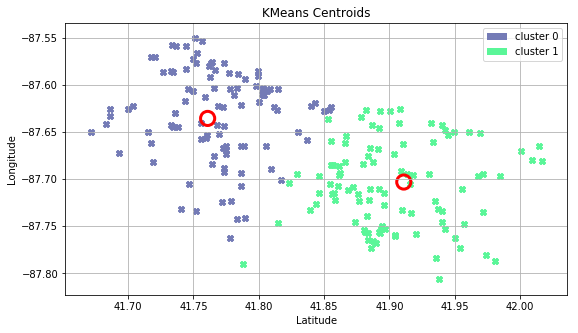

In [35]:
plot_2d_chart(centers,prediction)

In [92]:
# Set general coordinates of San Francisco city
COORDINATES = (41.881832, -87.623177) 

MAX_RECORDS = 100

In [93]:
m = folium.Map(location=COORDINATES, zoom_start=12)


In [94]:
list_loc=[]

list_pred=[]

for i in np.arange(0,k):
    pred = prediction.select("features","prediction").limit(200).collect()
    for x,y in pred:
        list_loc.append(x[0:2])
        list_pred.append(y)

In [134]:
color = ['green', 'gray', 'lightgreen', 'orange', 'pink', 'lightgray', 'blue', 'darkblue', 'black',
         'beige', 'darkred', 'cadetblue', 'purple', 'lightblue', 'darkpurple', 'darkgreen', 'lightred', 'red']
color_list = random.sample(color,k)
color_list

['gray', 'green']

In [135]:
#Painting the markers and circles in the map for Kmeans clustering
for i, l in enumerate(list_pred):
    folium.Marker(
        location = list_loc[i],
        popup="Cluster:"+str(l),
        icon=folium.Icon(color=color_list[l])).add_to(m)

In [136]:
folium.LayerControl().add_to(m)


In [137]:
m.save(outfile='/home/master/Escritorio/map_seda-homework2.html')

In [138]:
path = '/home/master/Escritorio/map_seda-homework2.html'
import os
rel_path = os.path.relpath(path)
from IPython.display import IFrame
IFrame(rel_path, width=900, height=650)